In [8]:
using Plots
using ImageView
using Images

##################################################################################
#ENCODING

#decodeert een afbeelding f, bestaande uit enkel grijstinten
function decode_channel(F)

    f = similar(F)
    C(u) = sqrt(1/2)^Float64(u==0);

    for blockx=0:(size(f,2)÷8-1)
        for blocky=0:(size(f,1)÷8 - 1)
            F_sub = F[ (blocky*8+1):(blocky*8+8), (blockx*8+1):(blockx*8+8)];
            u = (0:7)';
            v = (0:7)';
            for x=0:7
                cos_vec_xu = @. cos( (2* x + 1) * u * pi/16);
                for y=0:7
                    cos_vec_yv = @. cos( (2* y + 1) * (0:7)' * pi/16);

                    cos_vec = (cos_vec_xu' * cos_vec_yv);
                    C_sub = @. C(u)' * C(v);

                    tot = sum(sum( F_sub .* C_sub .* cos_vec));

                    f[blocky*8 + x + 1, blockx*8 + y + 1] = 1/4*tot;
                end
            end
        end
    end

    f = f .+ 128;

    return f

end

#encodeert een afbeelding f, bestaande uit enkel grijstinten
function encode_channel(f)
    f = f .- 128;

    F = similar(f)
    C(u) = sqrt(1/2)^Float64(u==0);

    for blockx=0:(size(f,2)÷8-1)
        for blocky=0:(size(f,1)÷8 - 1)
            f_sub = f[(blocky*8+1):(blocky*8+8), (blockx*8+1):(blockx*8+8)];
            for u=0:7

                cos_vec_xu = @. cos( (2* (0:7)' + 1) * u * pi/16);
                for v=0:7
                    cos_vec_yv = @. cos( (2* (0:7)' + 1) * v * pi/16);
                    cos_vec = (cos_vec_yv' * cos_vec_xu);

                    tot = sum(sum( f_sub .* cos_vec));

                    F[blocky*8 + v + 1, blockx*8 + u + 1] = 1/4*C(u)*C(v)*tot;
                end
            end
        end
    end
    
    return F

end

##################################################################################
#QUANTIZATION

#quantizet een color channel
function quantize_channel(F, q)
    newF = similar(F)
    for blockx=0:(size(F,2)÷8-1)
        for blocky=0:(size(F,1)÷8 - 1)
            F_sub = F[ (blocky*8+1):(blocky*8+8), (blockx*8+1):(blockx*8+8)];
    
            F_sub = floor.(0.5 .+ F_sub ./ q);
            #F_sub = 0.5 .+ F_sub ./ q
            newF[ (blocky*8+1):(blocky*8+8), (blockx*8+1):(blockx*8+8)] = F_sub;
        end
    end
    return newF
end

#dequantized een color channel
function dequantize_channel(F, q)
    newF = similar(F)
    for blockx=0:(size(F,2)÷8-1)
        for blocky=0:(size(F,1)÷8 - 1)
            F_sub = F[(blocky*8+1):(blocky*8+8), (blockx*8+1):(blockx*8+8)];
            F_sub = F_sub .* q;
            newF[ (blocky*8+1):(blocky*8+8), (blockx*8+1):(blockx*8+8)] = F_sub;
        end
    end
    return newF
end

##################################################################################
#UTILITY

function ycbcr_to_rgb(Y, Cb, Cr)
    R = min(max(0, floor(0.5 + (Y + 1.402*(Cr - 128)) )), 255);
    G = min(max(0, floor(0.5 + (Y - (0.114*1.772*(Cb-128)+0.299*1.402*(Cr-128))/0.587))),255);
    B = min(max(0, floor(0.5 + (Y + 1.772*(Cb - 128)))), 255);
    
    return R, G, B
end

function rgb_to_ycbcr(R, G, B)
    Y = (min(max(0, floor(0.5 + (0.299*R + 0.587*G + 0.114*B))), 255));
    Cb = (min(max(0, floor(0.5 + (-0.299*R - 0.587*G + 0.886*B)/1.772 + 128)),255));
    Cr = (min(max(0, floor(0.5 + (0.701*R - 0.587*G - 0.114*B)/1.402 + 128)),255));
    return Y, Cb, Cr
end


#voert functie uit op de drie kanalen tegelijk, en plakt ze dan terug aan elkaar
function three_channels(func, varargin)
    Ic = varargin{1};
    if nargin == 2
        out1 = func(Ic(:,:,1));
        out2 = func(Ic(:,:,2));
        out3 = func(Ic(:,:,3));
    elseif nargin == 4
        Qlum = varargin{2};
        Qchr = varargin{3};
        out1 = func(Ic(:,:,1), Qlum);
        out2 = func(Ic(:,:,2), Qchr);
        out3 = func(Ic(:,:,3), Qchr);
    else
        disp("error in three channels")
    end
    
    out = cat(3, out1, out2, out3);
    return out
end

#padding is vrije keuze volgens de standaard
#spiegelen aan de randen lijkt mij wel interessant
#of gewoon afbeeldingen gebruiken wiens afmetingen een veelvoud zijn van 8
function pad_channel(Ig)
    ex = mod(size(Ig,2),8);
    ey = mod(size(Ig,1),8);
    if ex != 0
        ex = 8 - ex;
    end
    if ey != 0
        ey = 8 - ey;
    end

    a = 0;
    Ig[:, size(Ig,2):(size(Ig,2) + ex)] = a;
    Ig[size(Ig,1):(size(Ig,1) + ey), :] = a;
    
    return Ig
end



┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1278


pad_channel (generic function with 1 method)

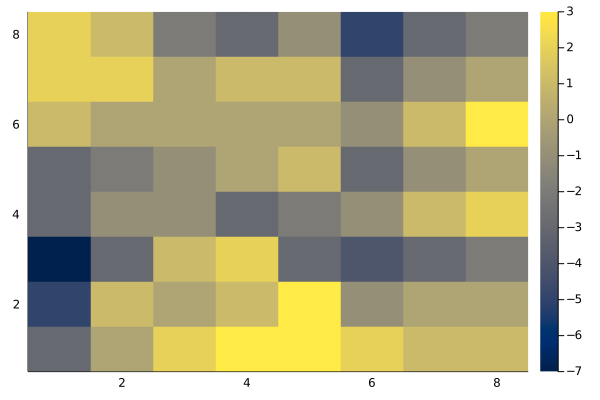

In [9]:
#jpeg_example
#toon het hele JPEG proces op een grijze 8x8 afbeelding

#quantization table:
qt = [
    16 11 10 16 24  40  51  61;
    12 12 14 19 26  58  60  55;
    14 13 16 24 40  57  69  56;
    14 17 22 29 51  87  80  62;
    18 22 37 56 68  109 103 77;
    24 35 55 64 81  104 113 92;
    49 64 78 87 103 121 120 101;
    72 92 95 98 112 100 103 99;
    ];

#Test image from JPEG standard document for verification
f = 
[139 144 149 153 155 155 155 155;
144 151 153 156 159 156 156 156;
150 155 160 163 158 156 156 156;
159 161 162 160 160 159 159 159;
159 160 161 162 162 155 155 155;
161 161 161 161 160 157 157 157;
162 162 161 163 162 157 157 157;
162 162 161 161 163 158 158 158];

#encode
F = encode_channel(convert(Array{Float64,2}, f));

#quantize (i.e. compress)
F_quantized = quantize_channel(F, qt)

#hier zou Huffman moeten gebeuren, maar dat is voor een andere cursus

#dequantize
dF = dequantize_channel(F_quantized, qt)

#decode
df = floor.(decode_channel(dF).+0.5)
#opmerking: dit geeft een ander resultaat dan de originele JPEG paper,
#omdat ik op een andere manier afrond, een juistere naar mijn mening:
#-7.1/14 < -0.5, dus dat moet naar -1 worden afgerond naar mijn mening.
#In de JPEG paper wordt dit naar 0 afgerond. Moet ik ook mijn paper
#vermelden.

heatmap(f-df, color = :cividis) 

In [13]:
Pkg.add("ImageShow")

  Resolving package versions...
Updating `C:\Users\dejan\.julia\environments\JuliaPro_v1.5.3-1\Project.toml`
  [4e3cecfd] + ImageShow v0.2.3
No Changes to `C:\Users\dejan\.julia\environments\JuliaPro_v1.5.3-1\Manifest.toml`


In [36]:
#frequency_image
#dit scriptje visualiseert de verschillende frequenties die JPEG compressie
#gebruikt
using Images;

c = 1016;
T = ones(8*8 + 7, 8*8 + 7)*(-1);
F = zeros(8, 8);

for i=1:8
    for j=1:8
        F[i,j] = c;
        df = floor.(decode_channel(F));
        F[i,j] = 0;
        
        i1 = 1 + (i-1)*9;
        j1 = 1 + (j-1)*9;
        
        dfmax = maximum(maximum(df))
        dfmin = minimum(minimum(df))
        
        T[i1:(i1+7), j1:(j1+7)] = floor.( (df .- dfmin) / (dfmax - dfmin) * 255 .+ 0.5)
    end
end

#T = imresize(T, 12, 'nearest');
T[1:8, 1:8] .= 255; #anders is de bovenste tegel zwart.

Tr = deepcopy(T);
Tr[Tr .== -1] .= 255;
T[T .== -1] .= 0;

T = T / 255
Tr = Tr / 255


imshow(RGB.(Tr, T, T))
#cat(Tr, T, T, dims=3)


Dict{String,Any} with 4 entries:
  "gui"         => Dict{String,Any}("window"=>GtkWindowLeaf(name="", parent, wi…
  "roi"         => Dict{String,Any}("redraw"=>313: "map(clim-mapped image, inpu…
  "annotations" => 266: "input-88" = Dict{UInt64,Any}() Dict{UInt64,Any} 
  "clim"        => 265: "CLim" = CLim{RGB{Float64}}(RGB{Float64}(0.0,0.0,0.0), …

┌ Info: Precompiling ImageIO [82e4d734-157c-48bb-816b-45c225c6df19]
└ @ Base loading.jl:1278
┌ Info: Precompiling PNGFiles [f57f5aa1-a3ce-4bc8-8ab9-96f992907883]
└ @ Base loading.jl:1278
┌ Info: Precompiling ImageMagick [6218d12a-5da1-5696-b52f-db25d2ecc6d1]
└ @ Base loading.jl:1278


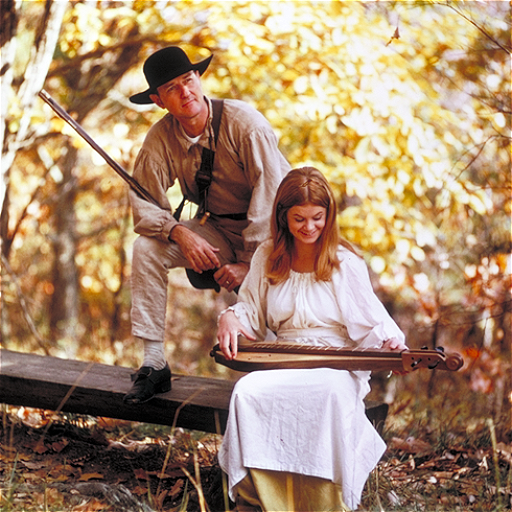

In [42]:
load("../couple.png")

In [6]:
#image decomposition
#deze code:
# 1) toont de originele foto
# 2) toont de R, G en B kanalen
# 3) toont de naive RGB -> YCbCr -> RGB afrondingsfout 
# 4) toont de Y, Cb en Cr kanalen

imgRGB = load('../couple.png'); #uit CSIQ
imshow(imgRGB); 

R = (imgRGB(:,:,1));
G = (imgRGB(:,:,2));
B = (imgRGB(:,:,3));

# toon de R,G,B kanalen
Z = zeros(size(R));


im = uint8(cat(3, R,Z,Z));
imshow(im);  #title('Red channel');

im = uint8(cat(3, Z,G,Z));
imshow(im); figure(3); #title('Green channel');

im = uint8(cat(3, Z,Z,B));
imshow(im); figure(4); #title('Blue channel');

#zet om naar YCbCr kleuren
Y,Cb,Cr = rgb_to_ycbcr(R,G,B);

#toon dat heen-en-weer gaan afrondingsfouten veroorzaakt
R2,G2,B2 = ycbcr_to_rgb(Y,Cb,Cr);


imagesc((R2 - R)); #title("Red rounding error");
 
imagesc((G2 - G)); #title("Green rounding error");

imagesc((B2 - B)); #title("Blue rounding error");

imagesc(max(max(abs(R2 - R), abs(G2 - G)), abs(B2 - B)));


# toon de Y, Cb en Cr kanalen
Z = ones(size(R));
s_lum = 128;
s_chr = 128;

[R,G,B] = ycbcr_to_rgb(Y, s_chr*Z, s_chr*Z);
im = uint8(cat(3, R,G,B));
imshow(im); #title('Y - luminance');


[R,G,B] = ycbcr_to_rgb(s_lum*Z, Cb, s_chr*Z);
im = uint8(cat(3, R,G,B));
imshow(im); #title('Cb - chrominance blue-yellow');

[R,G,B] = ycbcr_to_rgb(s_lum*Z, s_chr*Z, Cr);
im = uint8(cat(3, R,G,B));
imshow(im); #title('Cr - chrominance red-green');



LoadError: UndefVarError: clear not defined

In [7]:
#quality_comparison
#vergelijkt de qualiteit van het origineel met 
#high quality compression en low quality compression.

#high quality quantization tables:
hqL = [
     6  4  4  6  9 11 12 16;
     4  5  5  6  8 10 12 12;
     4  5  5  6 10 12 12 12;
     6  6  6 11 12 12 12 12;
     9  8 10 12 12 12 12 12;
    11 10 12 12 12 12 12 12;
    12 12 12 12 12 12 12 12;
    16 12 12 12 12 12 12 12;
    ];
hqC = [
      7  7 13 24 20 20 17 17;
      7 12 16 14 14 12 12 12;
     13 16 14 14 12 12 12 12;
     24 14 14 12 12 12 12 12;
     20 14 12 12 12 12 12 12;
     20 12 12 12 12 12 12 12;
     17 12 12 12 12 12 12 12;
     17 12 12 12 12 12 12 12
     ];
 
#low quality quantization tables:
lqL = [
     20 16 25 39 50 46 62 68;
     16 18 23 38 38 53 65 68;
     25 23 31 38 53 65 68 68;
     39 38 38 53 65 68 68 68;
     50 38 53 65 68 68 68 68;
     46 53 65 68 68 68 68 68;
     62 65 66 68 68 68 68 68;
     68 68 68 68 68 68 68 68;
     ];
 lqC = [
     21 25 32 38 54 68 68 68;
     25 28 24 38 54 68 68 68;
     32 24 32 43 66 68 68 68;
     38 38 43 53 68 68 68 68;
     54 54 66 68 68 68 68 68;
     68 68 68 68 68 68 68 68;
     68 68 68 68 68 68 68 68;
     68 68 68 68 68 68 68 68
     ];
 
 #lees de afbeelding
 f = double(load('../couple.png'));
 
 #zet afbeelding om naar YCbCr
 [Y, Cb, Cr] = rgb_to_ycbcr(f(:,:,1), f(:,:,2), f(:,:,3));
 f_ycbcr = cat(3,Y,Cb,Cr);
 
 #bereken de DCT van elk kanaal
 F = three_channels(encode_channel, f_ycbcr);
 
 #quantize met lage resp. kwaliteit
 FQ_lq = three_channels(quantize_channel, F, lqL, lqC);
 FQ_hq = three_channels(quantize_channel, F, hqL, hqC);
 
 #huffman hier
 #...
 
 #ont-huffman hier
 #...
 
 #dequantize met lage resp. hoge kwaliteit
 dFQ_lq = three_channels(dequantize_channel, FQ_lq, lqL, lqC);
 dFQ_hq = three_channels(dequantize_channel, FQ_hq, hqL, hqC);
 
 #inverse dct
 df_lq = three_channels(decode_channel, dFQ_lq);
 df_hq = three_channels(decode_channel, dFQ_hq);
 
 #zet terug om naar rgb
 [R,G,B] = ycbcr_to_rgb(df_lq(:,:,1), df_lq(:,:,2), df_lq(:,:,3));
 df_lq_rgb = cat(3, R,G,B);
 [R,G,B] = ycbcr_to_rgb(df_hq(:,:,1), df_hq(:,:,2), df_hq(:,:,3));
 df_hq_rgb = cat(3, R,G,B);
   
 
 #toon de resultaten 
 figure(1); imshow(uint8(f)); figure(1); #title('original image');
 
 figure(2); imshow(uint8(df_hq_rgb)); figure(2); #title('high quality jpeg');
 
 figure(3); imshow(uint8(df_lq_rgb)); figure(3); #title('low quality jpeg');
 
 figure(4); imagesc(max(abs(f-df_hq_rgb), [], 3)); figure(4);
 colorbar; #title('high quality deviation');
 
 figure(5); imagesc(max(abs(f-df_lq_rgb), [], 3)); figure(5); 
 colorbar; #title('low quality deviation');
 
 
#zoom in op het gezicht
 ri = 200:240;
 rj = 280:320;
 
 figure(6); imshow(imresize(uint8(f(ri,rj,:)), 20, 'nearest')); figure(6); #title('original image');
 
 figure(7); imshow(imresize(uint8(df_hq_rgb(ri,rj,:)), 20, 'nearest')); figure(7); #title('high quality jpeg');
 
 figure(8); imshow(imresize(uint8(df_lq_rgb(ri,rj,:)), 20, 'nearest')); figure(8); #title('low quality jpeg');
 
 
 
 
 
 
 

LoadError: syntax: character literal contains multiple characters